<a href="https://colab.research.google.com/github/krooner/CS470-homework/blob/main/Copy_of_CS470_Assignment_2_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS470 Assignment #2: Neural Style Transfer

Primary TA: Hyunsu Kim

TA's E-mail: khszone02@kaist.ac.kr

## Instruction
- There are total **two models** for the neural style transfer in this homework.
- Fill in the code blocks enveloped with some comments
- Refer to [the neural style transfer paper](https://arxiv.org/pdf/1508.06576.pdf) or the lecture slide for the first neural style transfer model.
- Refer to [the fast neural style transfer paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) or the lecture slide for the second neural style transfer model.
- There are total **10 problems**. Only the last problem (10) is for the second model. You have to start the **problem 10** as soon as possible if you want to get a score for the second model (20%). **It will take lots of time** in aspects of both coding and learning times.

## Submission guidelines
- *(The first and second model)* **Don't revise the codes except the commented blocks when you submit this notebook.**
- *(The second model)* The TAs should be able to reproduce your results using your code and pre-trained model. **Please double-check if your code runs without error and loads your pre-trained model properly.** Submissions failed to run or reproduce the results will get a substantial penalty.

## Deliverables
- Download your **Notebook file (*for the first and second model*)**, **style/content/synthsized images (*for the first and second model*)**, and the **checkpoints (*only for the second model*)**, and submit a zip file in a format: [StudentID].zip. Please double-check that you locate and load your pre-trained model (checkpoints) properly.
- Your assignment should be submitted through **KLMS**. All other submissions (e.g., via email) will not be considered as valid submissions.

## Grading policy
- **Code** (100%): The filled code blocks should work well. **Each problem occupies some points** so that you get a score if you write appropriate code logic even though the model doesn't work.
  - **The first model** (80%): Step 1-8
  - **The second model** (20%): Step 9 (will be taken lots of time)
- **Result** (Extra points): Extra points will be given if you generated a **naturally** synthesized image. If you generate an awful image such as so noisy image, an image that the style is not similar to the style image and so on. You should tune the hyperparameters to improve the image quality.

## Due date
Midnight October 30

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 2]" in the subject for all questions regarding this assignment (e.g., [Assignment 2] Regarding the grading policy).

## PyTorch Documentation
- You can refer PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html

## Step 0: Connect to Google drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data'

Mounted at /gdrive


## Step 1: Import modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms  # transform PIL images into tensors
import torchvision.models as models  # train or load pre-trained models
from torchvision import datasets

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Download images
Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions.

**Problem 1.** Pick images to merge. The style image should be an western painting (no margin).

In [ ]:
import urllib

##########################################################################
#### TODO: Download images to merge.                                  ####
####       The style image should be an western painting (no margin). ####
##########################################################################

# revise only image URLs

style_url = "https://www.pablopicasso.org/images/paintings/accordionist.jpg"
content_url = "https://cdn.images.express.co.uk/img/dynamic/36/590x/Joaquin-Phoenix-as-Joker-in-new-DC-movie-Joker-1185726.jpg?r=1570557109810"

opener = urllib.request.build_opener()
opener.addheaders = [(
    'User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36'
)]
urllib.request.install_opener(opener)

urllib.request.urlretrieve(style_url, 'style.jpg')
urllib.request.urlretrieve(content_url, 'content.jpg')

##########################################################################

!ls style.jpg content.jpg

content.jpg  style.jpg


In [ ]:
imsize = 256

preprocess = transforms.Compose([
  transforms.Resize(imsize),            # fixed size for both content and style images
  transforms.CenterCrop(imsize),        # crops the given PIL Image at the center.
  transforms.ToTensor(),                # range between 0 and 1
])

In [ ]:
# A PIL image to a Tensor
def image_loader(image_name, batch_size=None):
  image = Image.open(image_name)
  image = preprocess(image)
  if batch_size is None:
    image = image.unsqueeze(0)      # fake batch dimension for the pre-trained model input.
  else:
    image = image.repeat(batch_size, 1, 1, 1)

  return image.to(device, torch.float)

In [ ]:
# A Tensor to a PIL image
def imshow(tensor, title=None, save=None):
  unloader = transforms.ToPILImage()
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  if save:
    image.save(save)

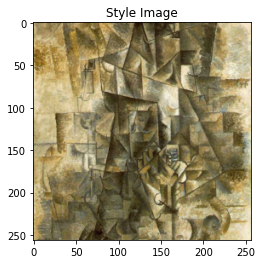

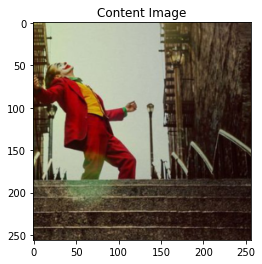

In [ ]:
style_img = image_loader("./style.jpg")
content_img = image_loader("./content.jpg")

plt.ion()

plt.figure()
imshow(style_img, title='Style Image', save=gdrive_data+'/style.jpg')  # save at Google drive my_data directory

plt.figure()
imshow(content_img, title='Content Image', save=gdrive_data+'/content.jpg')

## Step 3: Preload the pre-trained model
Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper. PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


## Step 4: Define the loss functions

$$P^* = \underset{P}{\mathrm{argmin}}\ \mathcal{L}_{content}(P, X) + \lambda\mathcal{L}_{style}(P, Y)$$
P is an input image, X is a content image, and Y is a style image.
### Content Loss
$$\mathcal{L}_{content}(P, X) = \sum_l\sum_{i, j}w_l\biggr(F_{i,j}^{X,l} - F_{i,j}^{P,l}\biggr)^2$$
l is the layer, F_ij is a ith row and jth column of a feature, and w is a weight.

**Problem 2.** Define the content loss for a layer. Don't regard weights, which is computed inside the optimization.

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()  # the feature tensor of the content image

  def forward(self, input):
    ################################################################################
    #### TODO: Define the content loss for a layer.                             ####
    ####       Don't regard weights, which is computed inside the optimization. ####
    #### Input:                                                                 ####
    ####   - input: the feature tensors of (a, b, c, d) size, where             ####
    ####            a = batch size (= 1)                                        ####
    ####            b = number of feature maps                                  ####
    ####            (c, d) = dimensions of a feature map (N=c*d)                ####
    #### Output:                                                                ####
    ####   - input                                                              ####
    ################################################################################

    self.loss = F.mse_loss(input, self.target)

    ################################################################################
    return input

### Style Loss
$$\mathcal{L}_{style}(P, Y) = \sum_l\sum_{i, j}w_l\biggr(G_{i,j}^{Y,l} - G_{i,j}^{P,l}\biggr)^2$$
$$\mathrm{(Gram\ matrix)}\ G = F^TF$$
l is the layer, G_ij is a ith row and jth column of a gram matrix, and w is a weight.

**Problem 3.** Define the gram matrix.

In [ ]:
def gram_matrix(input):
  ################################################################################
  #### TODO: Define the gram matrix.                                          ####
  #### Input:                                                                 ####
  ####   - input: the feature tensors of (a, b, c, d) size, where             ####
  ####            a = batch size (= 1)                                        ####
  ####            b = number of feature maps                                  ####
  ####            (c, d) = dimensions of a feature map (N=c*d)                ####
  #### Output:                                                                ####
  ####   - G: the gram matrix of (b, b) size                                  ####
  ################################################################################

  a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

  features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

  G = torch.mm(features, features.t())  # compute the gram product

  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(a * b * c * d)
  
  ################################################################################
  # return G

**Problem 4.** Define the style loss for a layer with the gram matrix. Don't regard weights, which is computed inside the optimization.

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    # self.target = target.detach()  # the feature tensor of the style image
    self.target = gram_matrix(target).detach()

  def forward(self, input):
    ################################################################################
    #### TODO: Define the style loss for a layer with the gram matrix.          ####
    ####       Don't regard weights, which is computed inside the optimization. ####
    #### Input:                                                                 ####
    ####   - input: the feature tensors of (a, b, c, d) size, where             ####
    ####            a = batch size (= 1)                                        ####
    ####            b = number of feature maps                                  ####
    ####            (c, d) = dimensions of a feature map (N=c*d)                ####
    #### Output:                                                                ####
    ####   - input                                                              ####
    ################################################################################

    self.loss = F.mse_loss(gram_matrix(input), self.target)

    ################################################################################
    return input

## Step 5: Transfer model

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [ ]:
class NormalizationLayer(nn.Module):
  def __init__(self, mean, std):
    super(NormalizationLayer, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting.

**Problem 5.** Decide on which layers to compute the content loss and the style loss.

In [ ]:
######################################################################################
#### TODO: Decide on which layers to compute the content loss and the style loss. ####
######################################################################################

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

######################################################################################

In [ ]:
def transfer_model(cnn, style_img, content_img):
  
  # import the pre-trained model
  cnn = copy.deepcopy(cnn)
  
  # initialize the transfer model with a normalization layer first
  normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  model = nn.Sequential(NormalizationLayer(normalization_mean, normalization_std).to(device))

  content_losses = []
  style_losses = []
  # stack the cnn layers on the transfer model
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      name = f"relu_{i}"
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
      name = f"bn_{i}"
    else:
      raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")
    
    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module(f"content_loss_{i}", content_loss)
      content_losses.append(content_loss)
    
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module(f"style_loss_{i}", style_loss);
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
      
  model = model[:(i + 1)]

  return model, style_losses, content_losses

## Step 6: Define the style transfer

We will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content and style losses.

In [ ]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the model and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [ ]:
def merge_image(cnn, content_img, style_img, input_img,
                num_steps, style_weight, content_weight):

  # get a transfer model
  model, style_losses, content_losses = transfer_model(cnn, style_img, content_img)

  # get an optimizer
  output_img = input_img.clone()
  optimizer = get_input_optimizer(output_img)

  # start optimizing
  run = [0]
  while run[0] <= num_steps:
    def closure():
      output_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(output_img)
      style_score = 0
      content_score = 0
      for i, sl in enumerate(style_losses):
        style_score += style_weight[i] * sl.loss
      for j, cl in enumerate(content_losses):
        content_score += content_weight[j] * cl.loss

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print(f"run {run}:")
        print(f"Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f}")
        print()

      return style_score + content_score

    optimizer.step(closure)

  output_img.data.clamp_(0, 1)

  del model
  return output_img.cpu()

## Step 7: Run the style transfer
**Problem 6 (Optional).** Revise the hyperparameters if you need.

In [ ]:
###########################################################
#### TODO: Revise the hyperparameters if you need.     ####
###########################################################
NUM_STEPS = 300
STYLE_WEIGHTS = [1000000, 1000000, 1000000, 1000000, 1000000]
CONTENT_WEIGHTS = [1]

assert len(STYLE_WEIGHTS) == len(style_layers) and len(CONTENT_WEIGHTS) == len(content_layers), \
    "we need to set the number of weights equal to the number of the style and content losses"
###########################################################

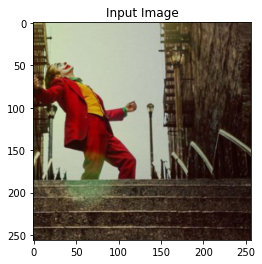

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


run [50]:
Style Loss: 34.281891 Content Loss: 13.508451

run [100]:
Style Loss: 10.689740 Content Loss: 11.644382

run [150]:
Style Loss: 4.106781 Content Loss: 9.474326

run [200]:
Style Loss: 2.199453 Content Loss: 7.906460

run [250]:
Style Loss: 1.486886 Content Loss: 6.947544

run [300]:
Style Loss: 1.217973 Content Loss: 6.412545



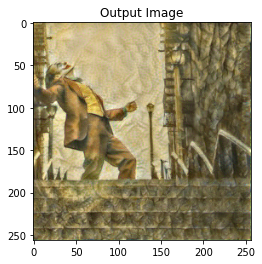

In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

output_img = merge_image(cnn, content_img, style_img, input_img,
                         NUM_STEPS, STYLE_WEIGHTS, CONTENT_WEIGHTS)

plt.figure()
imshow(output_img, title='Output Image', save=gdrive_data+'/baseline.jpg')

plt.ioff()
plt.show()

## Step 8: Improve the model with the total-variation regularization
$$\mathcal{L}_{total-variation} = w\sum_{c=1}^3\biggr(\sum_{i=1}^{H}\sum_{j=1}^{W-1}(x_{i,j+1,c} - x_{i,j,c})^2 + \sum_{i=1}^{H-1}\sum_{j=1}^{W}(x_{i+1,j,c}-x_{i,j,c})^2\biggr)$$
c is RGB, x_ijc is an element of input image tensor, and (H, W) is a size of an input image.

**Problem 7.** Define the total-variation loss.

In [ ]:
class TotalVariationLoss(nn.Module):
  def __init__(self):
    super(TotalVariationLoss, self).__init__()

  def forward(self, input):
    ################################################################################
    #### TODO: Define the total-variation loss.                                 ####
    #### Input:                                                                 ####
    ####   - input: the image tensors of (a, b, c, d) size, where               ####
    ####            a = batch size (= 1)                                        ####
    ####            b = RGB (= 3)                                               ####
    ####            (c, d) = size of the input image                            ####
    #### Output:                                                                ####
    ####   - input                                                              ####
    ################################################################################

    a, b, c, d = input.size()
    w_variance = torch.sum(torch.pow(input[:,:,:,:-1] - input[:,:,:,1:], 2))
    h_variance = torch.sum(torch.pow(input[:,:,:-1,:] - input[:,:,1:,:], 2))

    self.loss = (w_variance + h_variance)/(a*b*c*d)

    
    ################################################################################
    return input

**Problem 8.** Define a new merg_image function regarding the totoal-variation loss.

In [ ]:
def merge_image_with_tv_loss(cnn, content_img, style_img, input_img,
                num_steps, style_weight, content_weight, tv_weight):
  
  # get a transfer model
  old_model, style_losses, content_losses = transfer_model(cnn, style_img, content_img)
  tv_loss = TotalVariationLoss()
  model = nn.Sequential(tv_loss, *old_model)  # add the total-variation loss in the beginning of the model

  #####################################################################################
  #### TODO: Define a new merg_image function regarding the totoal-variation loss. ####
  #####################################################################################


  output_img = input_img.clone()
  # optimizer = get_input_optimizer(output_img)
  optimizer = torch.optim.Adam([output_img.requires_grad_()])

  run = [0]
  while run[0] <= num_steps:
    def closure():
      output_img.data.clamp_(0, 1)

      optimizer.zero_grad()

      model(output_img)

      style_score = content_score = 0
      for si, sl in enumerate(style_losses):
        style_score += style_weight[si] * sl.loss
      for ci, cl in enumerate(content_losses):
        content_score += content_weight[ci] * cl.loss

      tv_score = tv_weight * tv_loss.loss
      loss = style_score + content_score + tv_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print(f"run {run}:")
        print(f"SL: {style_score.item():4f} CL: {content_score.item():4f} TL: {tv_score.item():4f}")
        print()

      return style_score + content_score + tv_score

    optimizer.step(closure)

  output_img.data.clamp_(0, 1)












  ####################################################################################
  del model
  del old_model
  return output_img.cpu()

**Problem 9 (Optional).** Revise the hyperparameters if you need.

In [ ]:
#######################################################
#### TODO: Revise the hyperparameters if you need. ####
#######################################################
TV_WEIGHT = 10000
#######################################################

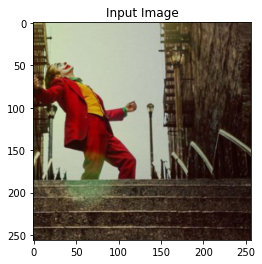

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


run [50]:
SL: 368.298309 CL: 5.528403 TL: 82.627647

run [100]:
SL: 202.986252 CL: 7.517603 TL: 80.801392

run [150]:
SL: 144.582672 CL: 8.595902 TL: 78.921867

run [200]:
SL: 113.634079 CL: 9.321205 TL: 77.090736

run [250]:
SL: 94.256912 CL: 9.845280 TL: 75.338913

run [300]:
SL: 80.893372 CL: 10.231627 TL: 73.712021



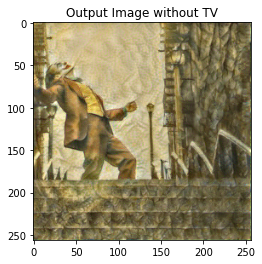

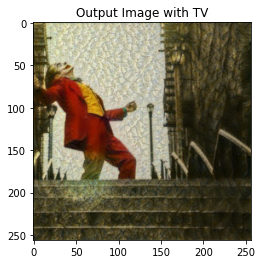

In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

output_img2 = merge_image_with_tv_loss(cnn, content_img, style_img, input_img,
                                      NUM_STEPS, STYLE_WEIGHTS, CONTENT_WEIGHTS, TV_WEIGHT)

plt.figure()
imshow(output_img, title='Output Image without TV')
imshow(output_img2, title='Output Image with TV', save=gdrive_data+'/tv_loss.jpg')

plt.show()

## Step 9: Fast neural style transfer with perceptual loss.
Refer to the paper, [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)

The previous neural style transfer model merged the content and style images through the optimization so that we had to retrain if the content image is changed.

In this paper, the authors suggested a method that exploits an input image passed through a network called Image Transform Net.
![Fast neural style transfer](https://hoya012.github.io/assets/img/fast_style_transfer/1.PNG)

### Download the COCO dataset

In [ ]:
import os
import urllib
import zipfile

if os.path.isdir("./val2017"):
  print("Dataset is already downloaded")
else:
  urllib.request.urlretrieve("http://images.cocodataset.org/zips/val2017.zip", "val2017.zip")
  val2017 = zipfile.ZipFile('./val2017.zip')
  val2017.extractall('.')
  val2017.close()
  print("COCO dataset is downloaded")

COCO dataset is downloaded


In [ ]:
urllib.request.urlretrieve("http://images.cocodataset.org/annotations/annotations_trainval2017.zip", "annotations_trainval2017.zip")
annotations_2017 = zipfile.ZipFile('./annotations_trainval2017.zip')
annotations_2017.extractall('.')
annotations_2017.close()

### Load the dataset

In [ ]:
BATCH_SIZE = 4

In [ ]:
train_dataset = datasets.ImageFolder(".", preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

FileNotFoundError: ignored

In [ ]:
style_img = image_loader("./style.jpg", batch_size=BATCH_SIZE)
content_img = image_loader("./content.jpg", batch_size=BATCH_SIZE)

plt.figure()
imshow(style_img[0], title='Style Image')

plt.figure()
imshow(content_img[0], title='Content Image')

### Define the Image Transform Net

In [ ]:
class ConvLayer(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super(ConvLayer, self).__init__()
    reflection_padding = kernel_size // 2
    self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

  def forward(self, x):
    out = self.reflection_pad(x)
    out = self.conv2d(out)
    return out

In [ ]:
class ResidualBlock(nn.Module):
  """ResidualBlock
  introduced in: https://arxiv.org/abs/1512.03385
  recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
  """

  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
    self.in1 = nn.InstanceNorm2d(channels, affine=True)
    self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
    self.in2 = nn.InstanceNorm2d(channels, affine=True)
    self.relu = nn.ReLU()

  def forward(self, x):
    residual = x
    out = self.relu(self.in1(self.conv1(x)))
    out = self.in2(self.conv2(out))
    out = out + residual
    return out


In [ ]:
class UpsampleConvLayer(nn.Module):
  """UpsampleConvLayer
  Upsamples the input and then does a convolution. This method gives better results
  compared to ConvTranspose2d.
  ref: http://distill.pub/2016/deconv-checkerboard/
  """

  def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
    super(UpsampleConvLayer, self).__init__()
    self.upsample = upsample
    reflection_padding = kernel_size // 2
    self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

  def forward(self, x):
    x_in = x
    if self.upsample:
      x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
    out = self.reflection_pad(x_in)
    out = self.conv2d(out)
    return out

In [ ]:
class TransformerNet(nn.Module):
  def __init__(self):
    super(TransformerNet, self).__init__()
    # Initial convolution layers
    self.encoder = nn.Sequential()
    
    self.encoder.add_module('conv1', ConvLayer(3, 32, kernel_size=9, stride=1))
    self.encoder.add_module('in1', nn.InstanceNorm2d(32, affine=True))
    self.encoder.add_module('relu1', nn.ReLU())
    
    self.encoder.add_module('conv2', ConvLayer(32, 64, kernel_size=3, stride=2))
    self.encoder.add_module('in2', nn.InstanceNorm2d(64, affine=True))
    self.encoder.add_module('relu2', nn.ReLU())
    
    self.encoder.add_module('conv3', ConvLayer(64, 128, kernel_size=3, stride=2))
    self.encoder.add_module('in3', nn.InstanceNorm2d(128, affine=True))
    self.encoder.add_module('relu3', nn.ReLU())

    # Residual layers
    self.residual = nn.Sequential()
    
    for i in range(5):
      self.residual.add_module('resblock_%d' %(i+1), ResidualBlock(128))
    
    # Upsampling Layers
    self.decoder = nn.Sequential()
    self.decoder.add_module('deconv1', UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2))
    self.decoder.add_module('in4', nn.InstanceNorm2d(64, affine=True))
    self.decoder.add_module('relu4', nn.ReLU())

    self.decoder.add_module('deconv2', UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2))
    self.decoder.add_module('in5', nn.InstanceNorm2d(32, affine=True))
    self.decoder.add_module('relu5', nn.ReLU())

    self.decoder.add_module('deconv3', ConvLayer(32, 3, kernel_size=9, stride=1))

  def forward(self, x):
    encoder_output = self.encoder(x)
    residual_output = self.residual(encoder_output)
    decoder_output = self.decoder(residual_output)
    
    return decoder_output

**Problem 10.** Complete the fast neural network model using the given networks and data loader above. You should implement both **"saving the trained model parameters (checkpoints)"** and **"loading the trained model parameters and evaluate the model"** to get full points.

In [ ]:
######################################################################################################
#### TODO: Complete the fast neural network model using the given networks and data loader above. ####
####       You should implement both "saving the trained model parameters (checkpoints)"          ####
####       and "loading the trained model parameters and evaluate the model"                      ####
####       to get full points.                                                                    ####
######################################################################################################

In [ ]:
######################################################################################################